<a href="https://colab.research.google.com/github/aaz25/431-2021/blob/main/double_descent_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Installation

In [ ]:
! pip install scikit-survival
! pip install pycox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

%matplotlib inline

from sklearn import set_config
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV

from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import integrated_brier_score, as_integrated_brier_score_scorer

from pycox.datasets import flchain

In [ ]:
np.random.seed(123)

# Dataset

In [ ]:
df_train = flchain.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)

Dataset 'flchain' not locally available. Downloading...
Done


In [ ]:
df_train.head()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death
0,97.0,0.0,1997,5.70,4.860,10,1.7,0.0,85.0,1.0
1,92.0,0.0,2000,0.87,0.683,1,0.9,0.0,1281.0,1.0
2,94.0,0.0,1997,4.36,3.850,10,1.4,0.0,69.0,1.0
3,92.0,0.0,1996,2.42,2.220,9,1.0,0.0,115.0,1.0
5,90.0,0.0,1997,2.01,1.860,9,1.0,0.0,1355.0,1.0


In [ ]:
x_cols = ['age','sex','sample.yr','kappa','lambda','flc.grp','creatinine',
          'mgus']
x_train = df_train[x_cols]
x_test = df_test[x_cols]
x_val = df_test[x_cols]

In [ ]:
# convert outcome into structured array for compatibility with sksurv models
to_y = lambda df: np.array(df.apply(lambda x: (x[9],x[8]),axis=1),
                                 dtype=[('death','bool'),('futime','<f4')])

y_train = to_y(df_train)
y_test = to_y(df_test)

# Random Survival Forest

In [ ]:
train_score = np.zeros(40)
test_score = np.zeros(40)
lower, upper = np.percentile(y_test['futime'],[10,90])
times = np.arange(lower,upper+1)
max_leaf = np.concatenate(([10],np.arange(100,2001,100),np.repeat(2000,19)))
n_tree = np.concatenate((np.repeat(1,20),np.arange(1,21)))

for i in range(0,40):
  rsf = RandomSurvivalForest(n_estimators=n_tree[i],max_leaf_nodes=max_leaf[i],
                             n_jobs=-1,random_state=1)
  model = as_integrated_brier_score_scorer(rsf,times).fit(x_train,y_train)
  train_score[i] = model.score(x_train,y_train) * -1
  test_score[i] = model.score(x_test,y_test) * -1
  print(f'n trees: {n_tree[i]:2} | max leaves: {max_leaf[i]:4} | \
  train score: {train_score[i]:.04} | test score: {test_score[i]:.04}')

n trees:    1 | max leaves: 10 |   train loss: 0.1232 | test loss: 0.1188
n trees:    1 | max leaves: 100 |   train loss: 0.1127 | test loss: 0.125
n trees:    1 | max leaves: 200 |   train loss: 0.1086 | test loss: 0.1372
n trees:    1 | max leaves: 300 |   train loss: 0.1074 | test loss: 0.149
n trees:    1 | max leaves: 400 |   train loss: 0.1061 | test loss: 0.1564
n trees:    1 | max leaves: 500 |   train loss: 0.1037 | test loss: 0.1615
n trees:    1 | max leaves: 600 |   train loss: 0.1019 | test loss: 0.1665
n trees:    1 | max leaves: 700 |   train loss: 0.1019 | test loss: 0.1665
n trees:    1 | max leaves: 800 |   train loss: 0.1019 | test loss: 0.1665
n trees:    1 | max leaves: 900 |   train loss: 0.1019 | test loss: 0.1665
n trees:    1 | max leaves: 1000 |   train loss: 0.1019 | test loss: 0.1665
n trees:    1 | max leaves: 1100 |   train loss: 0.1019 | test loss: 0.1665
n trees:    1 | max leaves: 1200 |   train loss: 0.1019 | test loss: 0.1665
n trees:    1 | max leave

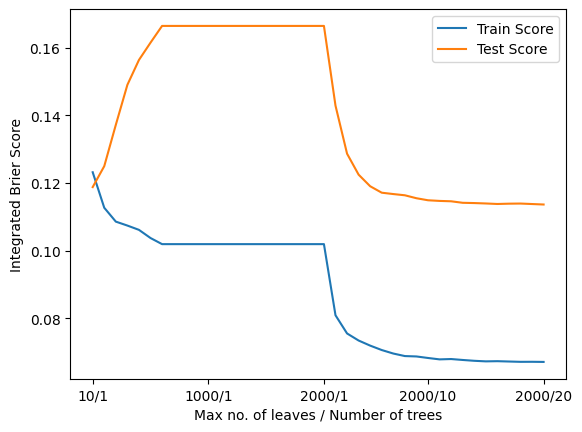

In [ ]:
plt.plot(np.arange(0,40),train_score,label='Train Score')
plt.plot(np.arange(0,40),test_score,label='Test Score')
plt.ylabel('Integrated Brier Score')
plt.xticks([0,10,20,29,39],['10/1','1000/1','2000/1','2000/10','2000/20'])
plt.xlabel('Max no. of leaves / Number of trees')
plt.legend()

# Gradient Boosting Survival Analysis

In [ ]:
param_grid = {'learning_rate': [0.0001,0.001,0.01,0.1,0.2,0.3]}
gbs = GradientBoostingSurvivalAnalysis(random_state=1)

def score_gb(model,x,y):
  survs = model.predict_survival_function(x)
  lower, upper = np.percentile(y['futime'],[10,90])
  times = np.arange(lower,upper+1)
  preds = np.asarray([[fn(t) for t in times] for fn in survs])
  return integrated_brier_score(y,y,preds,times)

gcv = GridSearchCV(gbs,param_grid,scoring=score_gb,n_jobs=-1)
gcv.fit(x_train,y_train)

GridSearchCV(estimator=GradientBoostingSurvivalAnalysis(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]},
             scoring=<function score_gb at 0x7f0a5ba13c70>)

In [ ]:
gcv.cv_results_

{'mean_fit_time': array([47.95601835, 47.92200909, 46.73767953, 46.95858359, 47.35197935,
        48.1081768 ]),
 'std_fit_time': array([1.05334254, 1.69981225, 1.44103004, 1.61137762, 1.61390255,
        2.37784579]),
 'mean_score_time': array([379.47074242, 373.85871644, 375.0964622 , 373.53162622,
        374.05747833, 356.77103329]),
 'std_score_time': array([102.20762779, 104.14775036, 101.69814253, 104.54294563,
        103.4196606 , 124.58801722]),
 'param_learning_rate': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.0001},
  {'learning_rate': 0.001},
  {'learning_rate': 0.01},
  {'learning_rate': 0.1},
  {'learning_rate': 0.2},
  {'learning_rate': 0.3}],
 'split0_test_score': array([0.3630206 , 0.35719637, 0.29946651, 0.20167126, 0.20536167,
        0.21369431]),
 'split1_test_score': array([0.18867666, 0.1879416 , 0.183121

In [ ]:
train_score = np.zeros(70)
test_score = np.zeros(70)
lower, upper = np.percentile(y_test['futime'],[10,90])
times = np.arange(lower,upper+1)
max_leaf = np.concatenate(([10],np.arange(100,2001,100),np.repeat(2000,49)))
n_tree = np.concatenate((np.repeat(1,20),np.arange(2,101,2)))

for i in range(0,70):
  gsb = GradientBoostingSurvivalAnalysis(learning_rate=0.2,
                                         n_estimators=n_tree[i],
                                         max_leaf_nodes=max_leaf[i],
                                         random_state=1)
  model = as_integrated_brier_score_scorer(gsb,times).fit(x_train,y_train)
  train_score[i] = model.score(x_train,y_train) * -1
  test_score[i] = model.score(x_test,y_test) * -1
  print(f'n trees: {n_tree[i]:2} | max leaves: {max_leaf[i]:4} | \
  train loss: {train_score[i]:.04} | test loss: {test_score[i]:.04}')

n trees:  1 | max leaves:   10 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves:  100 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves:  200 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves:  300 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves:  400 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves:  500 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves:  600 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves:  700 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves:  800 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves:  900 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves: 1000 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves: 1100 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves: 1200 |   train loss: 0.1586 | test loss: 0.156
n trees:  1 | max leaves: 1300 |   train loss: 0.15

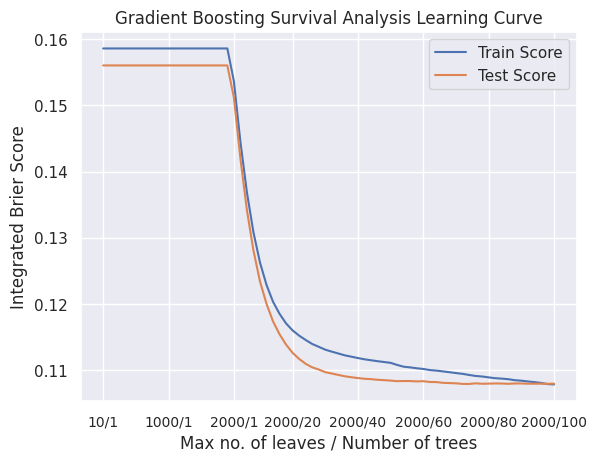

In [ ]:
plt.plot(np.arange(0,70),train_score,label='Train Score')
plt.plot(np.arange(0,70),test_score,label='Test Score')
plt.ylabel('Integrated Brier Score')
plt.xticks([0,10,20,29,39,49,59,69],
 ['10/1','1000/1','2000/1','2000/20','2000/40','2000/60','2000/80','2000/100'])
plt.tick_params(axis='x', which='major', labelsize=10)
plt.xlabel('Max no. of leaves / Number of trees')
plt.title('Gradient Boosting Survival Analysis Learning Curve')
plt.legend()